<a href="https://colab.research.google.com/github/fauxneticien/lnl-examples/blob/main/notebooks/01_mwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using PyTorch Lightning and Lhotse for speech processing research

<p align="center"><img width="500" src="https://user-images.githubusercontent.com/9938298/244146091-1e3cf317-910a-4fcf-a0e2-6e755a4935c0.png"></p>

This tutorial builds up to a minimal working example (MWE) of using [PyTorch Lightning](https://github.com/Lightning-AI/lightning) and [Lhotse](https://github.com/lhotse-speech/lhotse), two Python libraries that help with a lot of the necessary plumbing that can otherwise be tricky/time-consuming to take care of yourself (e.g. automatic mixed precision, dynamic batching, etc.).

We'll assume some basic level of familiarity of Python, deep learning, and speech processing and the main aim of the tutorial is to introduce how to get Lightning and Lhotse to play nice together. This notebook provides a component-by-component introduction with lots of prose and links that provide context for various choices in the accompanying `train_mwe.py` file.

## Setup

We'll assume the latest versions of `torch(audio)`, `lightning`, and `lhotse` as of early June 2023.

In [4]:
%%capture

!pip install --quiet torch==2.0.1 torchaudio==2.0.2 lightning==2.0.2 lhotse==1.14.0 gdown

## Model: DeepSpeech (Hannun et al., 2014)

For this introduction, we'll assume a very small, simple model, [DeepSpeech](https://arxiv.org/pdf/1412.5567.pdf), that is provided in `torchaudio`. For this tutorial, we'll just treat the model as a black box, and all we need to know is a) what kinds of inputs it wants and b) what kinds of outputs it gives back.

In [3]:
import torchaudio

# Hard-code for now (we'll see later how Lhotse can help derive this from the dataset)
labels="<pad>,<unk>,<bos>,<eos>, ,',A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z"

model = torchaudio.models.DeepSpeech(
    n_feature=80,
    n_class=len(labels.split(","))  # 32
  )

### Inputs (B, T, F)

Given the configuration above, the model will expect tensors of shape (B, T, F=80), where B is batch size, T is the number of time steps, and F is the number of features (80), which we'll obtain from using filter-bank features to process the raw audio.

To make this clear and concrete, let's have a look at a single utterance 'cat'.

#### Download and load audio

In [5]:
!gdown 15HIXKBA_0AeZOnaV9h0lciYs_I8VOaem

Downloading...
From: https://drive.google.com/uc?id=15HIXKBA_0AeZOnaV9h0lciYs_I8VOaem
To: /content/En-us-cat_16000.wav
100% 16.8k/16.8k [00:00<00:00, 76.3MB/s]


In [7]:
import IPython.display as ipd

samples, sample_rate = torchaudio.load("En-us-cat_16000.wav")

ipd.Audio(samples, rate=sample_rate)

#### Configure feature extractor

In [8]:
from lhotse import Fbank, FbankConfig

extractor = Fbank(FbankConfig(num_mel_bins=80))

#### Extract and view features

In [13]:
input_features = extractor.extract(samples, sampling_rate=sample_rate)

input_features

tensor([[-11.8135, -11.2680, -12.1239,  ...,  -7.6719,  -8.3827,  -8.1540],
        [-13.2961, -12.5913, -11.5908,  ...,  -7.5160,  -8.0119,  -7.8620],
        [-10.1926, -10.6146, -10.9565,  ...,  -4.2319,  -4.4798,  -5.3810],
        ...,
        [ -8.7502,  -8.8339, -11.2467,  ...,  -7.9184,  -7.5725,  -7.6966],
        [-10.8201,  -9.9903, -11.2561,  ...,  -8.0878,  -7.6657,  -7.4947],
        [-11.1634, -11.3071, -12.4587,  ...,  -8.3202,  -7.5953,  -7.1707]])

In [21]:
input_features.shape

torch.Size([52, 80])

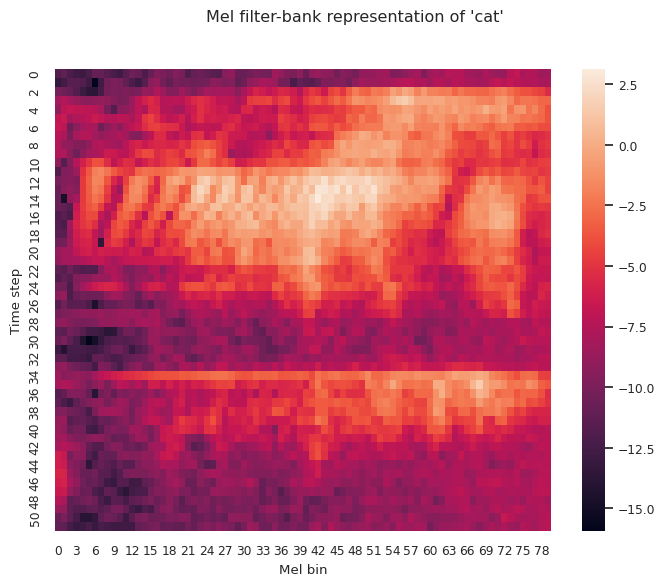

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
plt.suptitle("Mel filter-bank representation of 'cat'")

ax = sns.heatmap(input_features)
ax.set(xlabel='Mel bin', ylabel='Time step')

plt.show()

### Outputs (B, T, C)

#### Batch input and pass through model

In [25]:
# Make into shape [1, 52, 80] since we only have a single example
batch = input_features.unsqueeze(0)

outputs = model(batch)

outputs

tensor([[[-3.3492, -3.4953, -3.5039,  ..., -3.3062, -3.4314, -3.2946],
         [-3.3781, -3.4995, -3.5178,  ..., -3.2638, -3.4122, -3.2954],
         [-3.4161, -3.4786, -3.5664,  ..., -3.3051, -3.4399, -3.3465],
         ...,
         [-3.3429, -3.5268, -3.5152,  ..., -3.2572, -3.3843, -3.2768],
         [-3.3710, -3.5267, -3.4980,  ..., -3.2459, -3.4059, -3.2886],
         [-3.3866, -3.4846, -3.5341,  ..., -3.2613, -3.3805, -3.3281]]],
       grad_fn=<LogSoftmaxBackward0>)

In [41]:
# Recall from above (n_class=32) for labels:
# labels="<pad>,<unk>,<bos>,<eos>, ,',A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z"

outputs.shape

torch.Size([1, 52, 32])

#### Outputs from randomly initialized model

The shape of the output that we get back is `[B, T, C]`, where `B` is batch size, `T` is the number of time steps, and `C` is the number of labels we configured the model with.

In [27]:
import torch
import torch.nn.functional as F

# Get log probs
log_probs = F.log_softmax(outputs, dim=-1)
# Exponentiate get interpretable probabilities
probs  = torch.exp(log_probs)

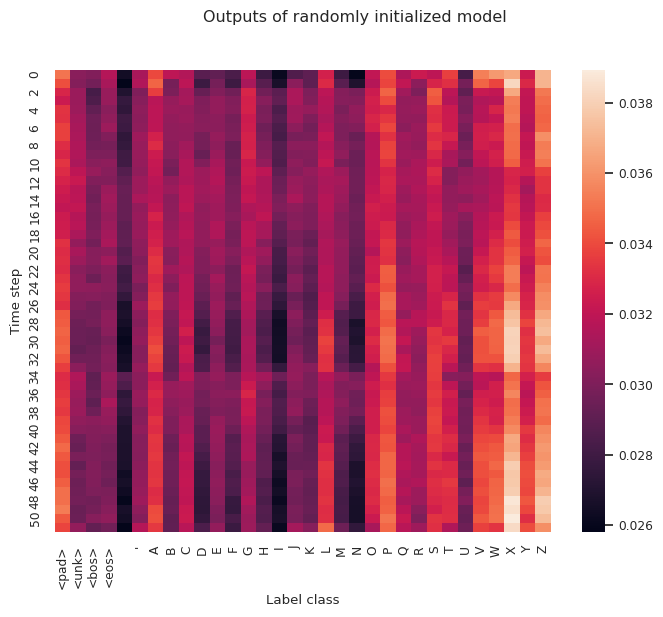

In [42]:
plt.figure(figsize=(8,6))
plt.suptitle("Outputs of randomly initialized model")

ax = sns.heatmap(
  probs.squeeze().detach().numpy(),
  xticklabels=labels.split(",")
)
ax.set(xlabel='Label class', ylabel='Time step')

plt.show()

#### Ideal output (for 'cat')

Ideally after training what we'd want the model to output is `C`, `A` and `T` around the time regions that correspond to those sounds in the input.

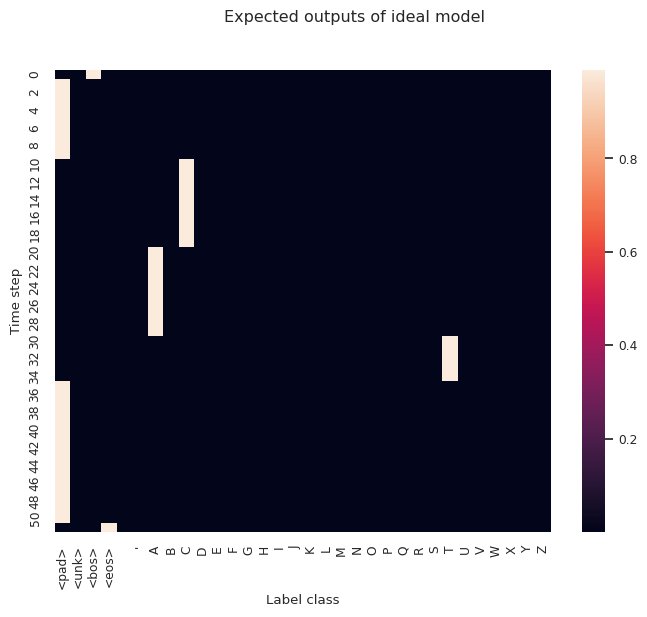

In [45]:
plt.figure(figsize=(8,6))
plt.suptitle("Expected outputs of ideal model")

ideal_outputs = torch.full((52, 32), (1-0.99)/31)           # Distribute remaining prob mass equally across other labels
ideal_outputs[10:20, labels.split(",").index("C")] = 0.99   # Some time steps are 'C'
ideal_outputs[20:30, labels.split(",").index("A")] = 0.99   # Some time steps are 'A'
ideal_outputs[30:35, labels.split(",").index("T")] = 0.99   # Some time steps are 'T'
ideal_outputs[1:10, 0] = 0.99                               # Fill rest with <pad>
ideal_outputs[35:51, 0] = 0.99                              # Fill rest with <pad>
ideal_outputs[0, labels.split(",").index("<bos>")] = 0.99
ideal_outputs[-1, labels.split(",").index("<eos>")] = 0.99

ax = sns.heatmap(
  ideal_outputs,
  xticklabels=labels.split(",")
)
ax.set(xlabel='Label class', ylabel='Time step')

plt.show()

## Loss function: CTC Loss, expects (T, B, C)

We'll use the [CTCLoss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) from PyTorch to iteratively adjust the model weights so that it eventually outputs something closer to the ideal output.

As far as I can tell the default options in `CTCLoss` for `reduction="mean"` and `zero_infinity=False` is probably retained for backwards compatability. In terms of reduction, the default behaviour is to normalize the losses by the lengths of the targets, however, the [more common practice](https://github.com/NVIDIA/NeMo/issues/68) these days is to divide the number of examples in the batch (so we set `reduction="sum"`). We also set `zero_infinity=True` to zero out any Inf losses.

Additionally, for future automatic mixed precision training (AMP) with Lightning, we'll force the loss calculations to happen in FP32, since CTC loss can be [quite demanding](https://discuss.pytorch.org/t/ctc-loss-ctc-loss-not-support-float16/148800/3) with regard to numerical accuracy. 

In [46]:
ctc_loss = torch.nn.CTCLoss(
    blank=labels.split(",").index('<pad>'),
    reduction="sum",
    zero_infinity=True
  )

### Usage

In [56]:
# Shape [1, 52, 80]
batch = input_features.unsqueeze(0)

# Shape [1, 52, 32]
outputs = model(batch)

# Require FP32 here
log_probs = F.log_softmax(
      outputs,
      dim=2,
      dtype=torch.float32
    ) 

loss = ctc_loss(
    # Reshape inputs to [52, 1, 32]
    log_probs.transpose(0, 1),
    # Targets are: ["<bos>", "C", "A", "T", "<eos>"]
    torch.tensor([[2, 8, 6, 25, 3]]),
    # Input lengths
    torch.tensor([52]),
    # Target lengths
    torch.tensor([5])
  )

# Normalize by number of examples in batch
loss *= 1 / batch.size(0)

## Dataset: Mini-LibriSpeech

Handily, Lhotse provides a 'Mini LibriSpeech', which consists of a subset of `train-clean` and `dev-clean`, for demos such as this. 

In [57]:
from lhotse.recipes import download_librispeech, prepare_librispeech

download_librispeech(dataset_parts="mini_librispeech")
libri = prepare_librispeech(corpus_dir="LibriSpeech", output_dir="data/")

Dataset parts:   0%|          | 0/2 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1519 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1089 [00:00<?, ?it/s]

Within the `train-clean-5` subset of `mini_librispeech`, we can see that Lhotse organizes the data into what they term 'Recordings' (e.g. audio) and 'Supervisions' (e.g. labels), as we can see from retrieving the first item from each set.

In [65]:
libri['train-clean-5']

{'recordings': RecordingSet(len=1519),
 'supervisions': SupervisionSet(len=1519)}

In [63]:
libri['train-clean-5']['recordings'][0]

Recording(id='1867-154075-0000', sources=[AudioSource(type='file', channels=[0], source='LibriSpeech/train-clean-5/1867/154075/1867-154075-0000.flac')], sampling_rate=16000, num_samples=235120, duration=14.695, channel_ids=[0], transforms=None)

In [64]:
libri['train-clean-5']['supervisions'][0]

SupervisionSegment(id='1867-154075-0000', recording_id='1867-154075-0000', start=0.0, duration=14.695, channel=0, text='CHAPTER TWELVE THE STRANGE BARGAIN RONICKY DREW HIS GUN AND WAITED GOOD SAID THE MAN OF THE SNEER GO AHEAD IT WAS DOWN IN THE CELLAR THAT WE FOUND THE FIRST TRACKS', language='English', speaker='1867', gender=None, custom=None, alignment=None)

These Recordings and Supervisions are combined into 'Cuts'. For an introduction to Lhotse's terms such as 'Cuts', 'Supervisions', etc., see their [documentation](https://lhotse.readthedocs.io/en/latest/) and examples on the [GitHub repo](https://github.com/lhotse-speech/lhotse/tree/master/examples).

In [66]:
from lhotse import CutSet

cuts_train = CutSet.from_manifests(**libri["train-clean-5"])
cuts_test = CutSet.from_manifests(**libri["dev-clean-2"])

In [87]:
# Use list() to force Colab to display cuts
list(cuts_train.subset(first=2))

[MonoCut(id='1867-154075-0000-0', start=0, duration=14.695, channel=0, supervisions=[SupervisionSegment(id='1867-154075-0000', recording_id='1867-154075-0000', start=0.0, duration=14.695, channel=0, text='CHAPTER TWELVE THE STRANGE BARGAIN RONICKY DREW HIS GUN AND WAITED GOOD SAID THE MAN OF THE SNEER GO AHEAD IT WAS DOWN IN THE CELLAR THAT WE FOUND THE FIRST TRACKS', language='English', speaker='1867', gender=None, custom=None, alignment=None)], features=None, recording=Recording(id='1867-154075-0000', sources=[AudioSource(type='file', channels=[0], source='LibriSpeech/train-clean-5/1867/154075/1867-154075-0000.flac')], sampling_rate=16000, num_samples=235120, duration=14.695, channel_ids=[0], transforms=None), custom=None),
 MonoCut(id='1867-154075-0001-1', start=0, duration=14.9, channel=0, supervisions=[SupervisionSegment(id='1867-154075-0001', recording_id='1867-154075-0001', start=0.0, duration=14.9, channel=0, text="THAT DROPPED HIM INTO THE COAL BIN DID HE GET COAL DUST ON HIS 

### Derive label set

So far we had hard-coded the labels, but now we can make use of Lhotse to help derive the label set from the training data and also a tokenizer to convert to and from text and integer representations of the labels.

In [69]:
from lhotse.dataset.collation import TokenCollater

tokenizer = TokenCollater(cuts_train)

We can access the list of the collated tokens as:

In [70]:
list(tokenizer.idx2token)

['<pad>',
 '<unk>',
 '<bos>',
 '<eos>',
 ' ',
 "'",
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

Additionally, we can use the tokenizer to map text to integers. Note also that the tokens the first, shorter utterance is 0-padded (since 0 = `<pad>`) so the returned tensor is rectangular.

In [89]:
tokens, token_lens = tokenizer(cuts_train.subset(first=2))

In [90]:
tokens

tensor([[ 2,  8, 13,  6, 21, 25, 10, 23,  4, 25, 28, 10, 17, 27, 10,  4, 25, 13,
         10,  4, 24, 25, 23,  6, 19, 12, 10,  4,  7,  6, 23, 12,  6, 14, 19,  4,
         23, 20, 19, 14,  8, 16, 30,  4,  9, 23, 10, 28,  4, 13, 14, 24,  4, 12,
         26, 19,  4,  6, 19,  9,  4, 28,  6, 14, 25, 10,  9,  4, 12, 20, 20,  9,
          4, 24,  6, 14,  9,  4, 25, 13, 10,  4, 18,  6, 19,  4, 20, 11,  4, 25,
         13, 10,  4, 24, 19, 10, 10, 23,  4, 12, 20,  4,  6, 13, 10,  6,  9,  4,
         14, 25,  4, 28,  6, 24,  4,  9, 20, 28, 19,  4, 14, 19,  4, 25, 13, 10,
          4,  8, 10, 17, 17,  6, 23,  4, 25, 13,  6, 25,  4, 28, 10,  4, 11, 20,
         26, 19,  9,  4, 25, 13, 10,  4, 11, 14, 23, 24, 25,  4, 25, 23,  6,  8,
         16, 24,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 2, 25, 13,  6, 25,  4,  9, 23, 20, 21, 21, 10,  9,  4, 13, 14, 18

In [91]:
token_lens

tensor([165, 204], dtype=torch.int32)

The tokenizer can also help inverse-map the integers back to characters:

In [97]:
tokenizer.inverse(tokens, token_lens)

['CHAPTER TWELVE THE STRANGE BARGAIN RONICKY DREW HIS GUN AND WAITED GOOD SAID THE MAN OF THE SNEER GO AHEAD IT WAS DOWN IN THE CELLAR THAT WE FOUND THE FIRST TRACKS',
 "THAT DROPPED HIM INTO THE COAL BIN DID HE GET COAL DUST ON HIS SHOES RIGHT AND HE DIDN'T HAVE SENSE ENOUGH TO WIPE IT OFF AN AMATEUR A RANK AMATEUR I TOLD YOU SAID THE MAN OF THE SNEER WITH SATISFACTION"]

### Derive features

Similary, we can use Lhotse to pre-process, pad and collate the input audio and return the inputs tensor as well as the lengths of each input prior to padding (the latter of which is needed for CTCLoss).

In [99]:
from lhotse.dataset import OnTheFlyFeatures
from lhotse import Fbank, FbankConfig

extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=80)))

feats, feat_lens = extractor(cuts_train.subset(first=2))

In [102]:
feats

tensor([[[-13.3677, -12.5139, -12.0247,  ...,  -9.9424,  -9.5791,  -9.3879],
         [-11.5933, -10.7378, -11.8656,  ...,  -8.6446,  -8.9839,  -8.9016],
         [-11.5576, -11.2481, -14.1217,  ...,  -8.9752,  -9.2986,  -9.6941],
         ...,
         [-23.0259, -23.0259, -23.0259,  ..., -23.0259, -23.0259, -23.0259],
         [-23.0259, -23.0259, -23.0259,  ..., -23.0259, -23.0259, -23.0259],
         [-23.0259, -23.0259, -23.0259,  ..., -23.0259, -23.0259, -23.0259]],

        [[-11.6992, -11.2629, -12.3218,  ...,  -7.9648,  -9.5093,  -9.9307],
         [-12.2117, -11.4504, -11.7851,  ...,  -9.2078,  -8.4604,  -9.0005],
         [-11.5948, -10.5698, -11.3569,  ...,  -9.5412,  -9.8638,  -9.3565],
         ...,
         [-13.2180, -12.1950, -13.5013,  ...,  -9.2887, -10.2001,  -9.8171],
         [-11.1315, -10.9054, -12.8678,  ...,  -9.0229,  -9.0606, -10.6329],
         [-12.6508, -11.3535, -11.5003,  ...,  -8.6241, -10.0400, -10.1408]]])

In [103]:
feats.shape

torch.Size([2, 1490, 80])

In [104]:
feat_lens

tensor([1470, 1490])

## Configure data loaders

We'll be leveraging the fact that both PyTorch Lightning and Lhotse are intended to play nice with PyTorch, in particular how PyTorch expects data loaders and samplers to behave.

For an in-depth discussion of how Lightning and (distributed) PyTorch data samplers and data loaders work, see [this Colab](https://colab.research.google.com/drive/1OFLZnX9y5QUFNONuvFsxOizq4M-tFvk-) written by [Adrian Wälchli](https://github.com/awaelchli), one of the engineers at Lightning. Similarly, the for how Lhotse extends the same base PyTorch classes for use with speech data, see [their documentation](https://lhotse.readthedocs.io/en/latest/datasets.html).

### Create dataset template

To avoid repeating ourselves for both the `train` and `test` datasets, we'll create a simple `MinimalASRDataset` for both splits.

In [109]:
class MinimalASRDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=80)))
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"inputs_padded": feats, "input_lengths": feat_lens, "labels_padded": tokens, "label_lengths": token_lens}

### Configure samplers with Lhotse's `BucketingSampler`

One of the big reasons to let Lhotse handle the data sampling is that it provides many ways to configure samplers and datasets that are common in speech processing, including `BucketingSampler`, where inputs of similar durations are grouped together into batches, which help reduce the amount of padding used.

**Important**
- That these batches are defined by a maximum duration (`max_duration`, in seconds) and so each batch can contain different numbers of examples.
- We use `drop_last=True` so that in distributed training with multiple GPUs the last batch can be dropped if not enough examples are left (Lightning's training loop can get stuck without this flag)

In [106]:
from lhotse.dataset import BucketingSampler

train_sampler = BucketingSampler(cuts_train, max_duration=300, shuffle=True, drop_last=True)
test_sampler  = BucketingSampler(cuts_test,  max_duration=300, shuffle=False, drop_last=True)

### Configure data loaders

In [110]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    MinimalASRDataset(),
    sampler=train_sampler,
    batch_size=None,
    num_workers=1
)

test_loader = DataLoader(
    MinimalASRDataset(),
    sampler=test_sampler,
    batch_size=None,
    num_workers=1
)

At the end of the day, we can see that the data loader (with various bells and whistles) is still just a PyTorch DataLoader:

In [111]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

As such we can ask for a batch. Note that it contains everything we need to pass into `model` and `ctc_loss` thereafter.

In [114]:
batch = next(iter(train_loader))

batch

{'inputs_padded': tensor([[[-14.8957, -13.9265, -14.8541,  ..., -10.1862, -10.2609,  -9.7772],
          [-14.1687, -12.8906, -12.9787,  ..., -10.2520, -10.5628,  -9.8027],
          [-13.8581, -13.4385, -15.9424,  ..., -10.5759, -10.0647, -10.2976],
          ...,
          [-13.5844, -12.1844, -12.6069,  ...,  -8.8400,  -8.6767,  -8.8120],
          [-12.9458, -12.3476, -14.4319,  ...,  -9.9672,  -9.5798, -10.0195],
          [-12.4982, -12.1000, -13.2070,  ...,  -9.8147,  -9.3877, -10.7631]],
 
         [[-12.4055, -12.2716, -13.8663,  ...,  -8.6725,  -9.2966,  -9.5031],
          [-12.6852, -11.3921, -11.2947,  ...,  -9.5668,  -9.4694,  -8.0842],
          [-11.2774, -10.2223,  -9.9931,  ...,  -9.1784,  -8.8316,  -9.0008],
          ...,
          [-11.8495, -11.1182, -10.4742,  ...,  -7.4367,  -7.9385,  -8.4386],
          [-23.0259, -23.0259, -23.0259,  ..., -23.0259, -23.0259, -23.0259],
          [-23.0259, -23.0259, -23.0259,  ..., -23.0259, -23.0259, -23.0259]],
 
         [[

## Configure PyTorch Lightning  (MWE)

We're just about ready to train our model. We can more or less follow the template from [Lightning in 15 minutes](https://lightning.ai/docs/pytorch/2.0.2/starter/introduction.html), with some slight adjustments for our speech use case.

For the time being, we'll also hard-code some hyperparameters (e.g. learning rate) before we add on fancier ways of adjusting things by command-line input.

### Configure `LightningModule`

In [115]:
import lightning.pytorch as pl

MAX_STEPS=10_000
LEARNING_RATE=1e-4

class DeepSpeechLightningModule(pl.LightningModule):
    def __init__(self, n_feature, tokenizer):
        super().__init__()
        # See Model section for details
        self.model    = torchaudio.models.DeepSpeech(n_feature=n_feature, n_class=len(list(tokenizer.idx2token)))
        # See Loss section for details
        self.ctc_loss = torch.nn.CTCLoss(blank=list(tokenizer.idx2token).index('<pad>'), reduction="sum", zero_infinity=True)

    def training_step(self, batch, batch_idx):
        # See loss usage section for details
        outputs   = self.model(batch['inputs_padded'])
        log_probs = F.log_softmax(outputs, dim=2, dtype=torch.float32)

        loss = self.ctc_loss(log_probs.transpose(0, 1), batch["labels_padded"], batch["input_lengths"], batch["label_lengths"])

        # For multi-GPU training, normalize the loss based on the sum of batch_size across all GPUs
        batch_size = batch['inputs_padded'].size(0)
        # Get batch sizes from all GPUs
        batch_sizes = self.all_gather(batch_size)
        # Normalize by world size / batch size
        loss *= batch_sizes.size(0) / batch_sizes.sum()

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=MAX_STEPS, anneal_strategy='linear')

        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "step", 'frequency': 1 }
        }

### Configure `Trainer`


In [132]:
# Skip cell in Colab
%%script echo ""

trainer = pl.Trainer(
    max_steps=MAX_STEPS,
    max_epochs=-1,
    strategy="ddp",
    use_distributed_sampler=False,
    # Disabled for this minimal working example
    enable_checkpointing=False,
    enable_model_summary=False,
    logger=None,
    limit_val_batches=0
)

### Run training

In [133]:
# Skip cell in Colab
%%script echo ""

trainer.fit(
  DeepSpeechLightningModule(80, tokenizer),
  train_dataloaders=train_loader
)